In [1]:
from openai import OpenAI

import pandas as pd
import random
import json

import googlemaps
from datetime import datetime

import re
import requests

import os
import matplotlib.pyplot as plt

import numpy as np
from scipy.interpolate import interp1d

import math


In [2]:
json_file_path = 'goals_data.json'

In [3]:
# Read the JSON file
with open(json_file_path, 'r') as file:
    data = json.load(file)

# Initialize variables
initial_location = data[1]['initial']
goals_list = data[1]['goals']
observations = data[2]['observations']

# Print or use the variables as needed
print("Initial Location:", initial_location)
print("Goals List:", goals_list[1])
print("observations:", observations)

Initial Location: Bristol, UK
Goals List: Derby, UK
observations: [[51.4551987, -2.5868899], [51.4597708, -2.5840761], [52.3522323, -1.809647], [52.9488481, -1.1506018], [52.95400799999999, -1.1552171]]


In [4]:
# def calculate_similarity(route1, route2):
#     path1 = route1  # Assuming route1 is a list of coordinates
#     path2 = route2  # Assuming route2 is a list of coordinates

#     if len(path1) == 0 and len(path2) == 0:
#         return 1000  # If either path is empty, consider them 100% similar

#     common_points = [point1 for point1 in path1 if any(are_points_equal(point1, point2) for point2 in path2)]

#     similarity_percentage = (len(common_points) / max(len(path1), len(path2))) * 100

#     # if similarity_percentage > 100:
#     #     return 100

#     return similarity_percentage

# def are_points_equal(point1, point2):
#     epsilon = 1e-5
#     lat_diff = abs(point1[0] - point2[0])
#     lng_diff = abs(point1[1] - point2[1])

#     return lat_diff < epsilon and lng_diff < epsilon



In [5]:

def normalize_paths(path1, path2):
    length1 = len(path1)
    length2 = len(path2)

    if length1 == length2:
        return path1, path2  # Paths already have the same length

    normalized_path1 = path1.copy()
    normalized_path2 = path2.copy()

    # Interpolate additional points along the shorter path
    if length1 < length2:
        normalized_path1 = interpolate_path(path1, length2)
    else:
        normalized_path2 = interpolate_path(path2, length1)

    return normalized_path1, normalized_path2

def interpolate_path(path, target_length):
    interpolated_path = []

    for i in range(target_length):
        index = math.floor((i / (target_length - 1)) * (len(path) - 1))
        interpolated_path.append(path[index])

    return interpolated_path

def calculate_distance(point1, point2):
    R = 6371e3  # Earth radius in meters
    lat1, lon1 = point1
    lat2, lon2 = point2
    φ1 = math.radians(lat1)
    φ2 = math.radians(lat2)
    Δφ = math.radians(lat2 - lat1)
    Δλ = math.radians(lon2 - lon1)

    a = math.sin(Δφ / 2) * math.sin(Δφ / 2) + math.cos(φ1) * math.cos(φ2) * math.sin(Δλ / 2) * math.sin(Δλ / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c  # Distance in meters

def calculate_similarity(route1, route2):
    normalized_route1, normalized_route2 = normalize_paths(route1, route2)

    max_length = max(len(normalized_route1), len(normalized_route2))
    total_distance = 0
    similar_points = 0

    for i in range(max_length):
        point1 = normalized_route1[math.floor(i * len(normalized_route1) / max_length)]
        point2 = normalized_route2[math.floor(i * len(normalized_route2) / max_length)]
        distance = calculate_distance(point1, point2)
        total_distance += distance
        if distance < 45:  # You can adjust this threshold according to your needs
            similar_points += 1

    similarity_percentage = (similar_points / max_length) * 100

    return min(similarity_percentage, 100)  # Ensure similarity doesn't exceed 100%

In [6]:
file_path = "locations_with_lat_lng.txt"
path_df = pd.read_csv(file_path)

def get_lat_lng(location):
    # Find the row corresponding to the input location
    row = path_df[path_df['Locations'] == location]

    # If location not found in DataFrame, return None
    if row.empty:
        return None, None
    
    # Extract latitude and longitude from the DataFrame
    return row['Latitude'].values[0], row['Longitude'].values[0]

In [7]:
# Read the JSON file
with open(json_file_path, 'r') as file:
    data = json.load(file)

datalength = len(data)


In [8]:
for current_id in range(3):
    goals = data[current_id]['goals']
    if current_id % 5 == 0: 
            for goal in range(len(goals)):
                print(data[current_id]['id'], data[current_id]['initial'], goals[goal])
    
    # for goal in range(len(goals)):
    #     print(data[current_id]['id'])
        # route_points = calculate_route_points(data[current_id]['initial'], goals[goal])
        # print(data[current_id]['id'],data[current_id]['initial'], goals[goal])

1.2.1 Bristol, UK Nottingham, UK
1.2.1 Bristol, UK Derby, UK


In [9]:
folder_path = 'data_output'

similarity_ai_csv_path = os.path.join(folder_path, 'similarity_ai.csv')
df_similarity_ai = pd.read_csv(similarity_ai_csv_path, index_col='ID')
similarity_file_ai = df_similarity_ai.to_dict(orient='index')

similarity_google_csv_path = os.path.join(folder_path, 'similarity_google.csv')
df_similarity_google = pd.read_csv(similarity_google_csv_path, index_col='ID')
similarity_file_google = df_similarity_google.to_dict(orient='index')

similarity_mapbox_csv_path = os.path.join(folder_path, 'similarity_mapbox.csv')
df_similarity_mapbox = pd.read_csv(similarity_mapbox_csv_path, index_col='ID')
similarity_file_mapbox = df_similarity_mapbox.to_dict(orient='index')

In [10]:
# similarity_file_google

In [11]:
similarity_dic_ai = {}
intent_dic_ai = {}


for current_id in range(datalength):
    intent = {}

    route_similarity_array = []

    point_distance_array = []
    
    goals = data[current_id]['goals']
    
    print(data[current_id]['id'], end=' ')
    
    for goal in range(len(goals)):
        
        
        route_similarity = similarity_file_ai[data[current_id]['id']][str(goal)]

        route_similarity_array.append(route_similarity)

        point_distance = calculate_distance(get_lat_lng(goals[goal]), data[current_id]['observations'][-1])
        # print(point_distance)
        point_distance_array.append(point_distance)

    
    similarity_dic_ai[data[current_id]['id']] = route_similarity_array 
    total_distance = sum(point_distance_array)

        # print(goals[goal], format(route_similarity, '.2f'))
        
    for i in range(len(goals)):
        intent_percentage = (route_similarity_array[i] / sum(route_similarity_array)) * 100
        h1_intent_percentage = (point_distance_array[i] / total_distance) * 100
    
        # Calculate the combined intent as described
        combined_intent_percentage = 0.9 * intent_percentage + 0.1 * h1_intent_percentage
        
        intent[goals[i]] = format(intent_percentage, '.2f')
    
    intent_dic_ai[data[current_id]['id']] = intent

#     print(intent)
# intent_dic_ai 

1.2.1 1.2.3 1.2.5 1.2.10 1.2.15 1.5.1 1.5.3 1.5.5 1.5.10 1.5.15 1.10.1 1.10.3 1.10.5 1.10.10 1.10.15 1.15.1 1.15.3 1.15.5 1.15.10 1.15.15 2.2.1 2.2.3 2.2.5 2.2.10 2.2.15 2.5.1 2.5.3 2.5.5 2.5.10 2.5.15 2.10.1 2.10.3 2.10.5 2.10.10 2.10.15 2.15.1 2.15.3 2.15.5 2.15.10 2.15.15 3.2.1 3.2.3 3.2.5 3.2.10 3.2.15 3.5.1 3.5.3 3.5.5 3.5.10 3.5.15 3.10.1 3.10.3 3.10.5 3.10.10 3.10.15 3.15.1 3.15.3 3.15.5 3.15.10 3.15.15 4.2.1 4.2.3 4.2.5 4.2.10 4.2.15 4.5.1 4.5.3 4.5.5 4.5.10 4.5.15 4.10.1 4.10.3 4.10.5 4.10.10 4.10.15 4.15.1 4.15.3 4.15.5 4.15.10 4.15.15 5.2.1 5.2.3 5.2.5 5.2.10 5.2.15 5.5.1 5.5.3 5.5.5 5.5.10 5.5.15 5.10.1 5.10.3 5.10.5 5.10.10 5.10.15 5.15.1 5.15.3 5.15.5 5.15.10 5.15.15 

In [12]:
TP_ai = 0
FN_ai = 0
FP_ai = 0
TN_ai = 0

count = 0  # Reset count for each iteration

for id in intent_dic_ai:
    highest_intent, highest_score = max(intent_dic_ai[id].items(), key=lambda x: float(x[1]))
    
    # Check if the highest scoring intent matches the intent_goal
    if highest_intent == data[count]['intent_goal']:
        TP_ai += 1
        TN_ai += len(intent_dic_ai[id]) - 1
    else:
        FN_ai += 1
        FP_ai += len(intent_dic_ai[id]) - 1
    
    count += 1  

# Calculate evaluation metrics, handle division by zero cases
TPR_recall_ai = TP_ai / (TP_ai + FN_ai)  # Ensuring the denominator is not zero
TPR_recall_ai

0.24

In [13]:
# Initialize counts
TP_ai = 0
FN_ai = 0
FP_ai = 0
TN_ai = 0
ai_intention = {}

count = 0  # Reset count for each iteration

for id in intent_dic_ai:
    highest_intent, highest_score = max(intent_dic_ai[id].items(), key=lambda x: float(x[1]))
    
    # Find all scores that are equal to the highest score
    highest_scores = [(key, value) for key, value in intent_dic_ai[id].items() if value == highest_score]
    point_distance_array = []

    if len(highest_scores) >= 2:
        for location, score in highest_scores:
            # Assuming 'location' is the name of the location
            lat_lng = get_lat_lng(location)
            if lat_lng is not None:
                point_distance = calculate_distance(lat_lng, data[count]['observations'][-1])
                point_distance_array.append((location, point_distance))
               
        shortest_distance_location = min(point_distance_array, key=lambda x: x[1])[0]
        highest_score_location = [loc for loc, _ in highest_scores]
        if shortest_distance_location in highest_score_location:
            highest_intent = shortest_distance_location

    # Check if the highest scoring intent matches the intent_goal
    if highest_intent == data[count]['intent_goal']:
        ai_intention[id] = 1
        TP_ai += 1
        TN_ai += len(intent_dic_ai[id]) - 1
    else:
        ai_intention[id] = 0
        FN_ai += 1
        FP_ai += len(intent_dic_ai[id]) - 1
    
    count += 1   

# Calculate evaluation metrics, handle division by zero cases
TPR_recall_ai = TP_ai / (TP_ai + FN_ai)  # Ensuring the denominator is not zero
Precision_ai = TP_ai / (TP_ai + FP_ai)  # Ensuring the denominator is not zero
FNR_ai = FN_ai / (FN_ai + TP_ai)  # Ensuring the denominator is not zero

# Calculate FPR, handle division by zero cases
FPR_ai = FP_ai / (FP_ai + TN_ai)  # Ensuring the denominator is not zero

# Calculate F1 score, handle division by zero cases
denominator = Precision_ai + TPR_recall_ai  # Ensuring the denominator is not zero
F1_ai = (2 * Precision_ai * TPR_recall_ai) / denominator

# Print or use the evaluation metrics as needed

In [14]:
TPR_recall_ai

0.25

In [15]:
FNR_ai

0.75

In [16]:
F1_ai

0.06906077348066299

In [17]:
similarity_dic_google = {}
intent_dic_google = {}


for current_id in range(datalength):
    intent = {}

    route_similarity_array = []

    point_distance_array = []
    
    goals = data[current_id]['goals']
    
    print(data[current_id]['id'], end=' ')
    
    for goal in range(len(goals)):
        
        
        route_similarity = similarity_file_google[data[current_id]['id']][str(goal)]

        route_similarity_array.append(route_similarity)

        point_distance = calculate_distance(get_lat_lng(goals[goal]), data[current_id]['observations'][-1])
        # print(point_distance)
        point_distance_array.append(point_distance)

    
    similarity_dic_google[data[current_id]['id']] = route_similarity_array 
    total_distance = sum(point_distance_array)

        # print(goals[goal], format(route_similarity, '.2f'))
        
    for i in range(len(goals)):
        intent_percentage = (route_similarity_array[i] / sum(route_similarity_array)) * 100
        h1_intent_percentage = (point_distance_array[i] / total_distance) * 100
    
        # Calculate the combined intent as described
        combined_intent_percentage = 0.9 * intent_percentage + 0.1 * h1_intent_percentage
        
        intent[goals[i]] = format(intent_percentage, '.2f')
    
    intent_dic_google[data[current_id]['id']] = intent

#     print(intent)
# intent_dic_ai 

1.2.1 1.2.3 1.2.5 1.2.10 1.2.15 1.5.1 1.5.3 1.5.5 1.5.10 1.5.15 1.10.1 1.10.3 1.10.5 1.10.10 1.10.15 1.15.1 1.15.3 1.15.5 1.15.10 1.15.15 2.2.1 2.2.3 2.2.5 2.2.10 2.2.15 2.5.1 2.5.3 2.5.5 2.5.10 2.5.15 2.10.1 2.10.3 2.10.5 2.10.10 2.10.15 2.15.1 2.15.3 2.15.5 2.15.10 2.15.15 3.2.1 3.2.3 3.2.5 3.2.10 3.2.15 3.5.1 3.5.3 3.5.5 3.5.10 3.5.15 3.10.1 3.10.3 3.10.5 3.10.10 3.10.15 3.15.1 3.15.3 3.15.5 3.15.10 3.15.15 4.2.1 4.2.3 4.2.5 4.2.10 4.2.15 4.5.1 4.5.3 4.5.5 4.5.10 4.5.15 4.10.1 4.10.3 4.10.5 4.10.10 4.10.15 4.15.1 4.15.3 4.15.5 4.15.10 4.15.15 5.2.1 5.2.3 5.2.5 5.2.10 5.2.15 5.5.1 5.5.3 5.5.5 5.5.10 5.5.15 5.10.1 5.10.3 5.10.5 5.10.10 5.10.15 5.15.1 5.15.3 5.15.5 5.15.10 5.15.15 

In [18]:
count = 0
TP_google = 0
FN_google = 0
FP_google = 0
TN_google = 0
for id in intent_dic_google:
    highest_intent, highest_score = max(intent_dic_google[id].items(), key=lambda x: float(x[1]))
    
    # Check if the highest scoring intent matches the intent_goal
    if highest_intent == data[count]['intent_goal']:
        # print(data[count]['id'])
        TP_google += 1
        TN_google += len(intent_dic_google[id]) - 1
    else:
        # print(data[count]['id'])
        FN_google += 1
        FP_google += len(intent_dic_google[id]) - 1
    
    count += 1  
TP_google

87

In [19]:
count = 0
TP_google = 0
FN_google = 0
FP_google = 0
TN_google = 0
google_intention = {}

for id in intent_dic_google:
    highest_intent, highest_score = max(intent_dic_google[id].items(), key=lambda x: float(x[1]))
    
    # Find all scores that are equal to the highest score
    highest_scores = [(key, value) for key, value in intent_dic_google[id].items() if value == highest_score]
    point_distance_array = []
    
    if len(highest_scores) >= 2:
        # print(highest_scores)
        for location, score in highest_scores:
            # Assuming 'location' is the name of the location
            lat_lng = get_lat_lng(location)
            # print(location)
            if lat_lng is not None:
                point_distance = calculate_distance(lat_lng, data[count]['observations'][-1])
                point_distance_array.append((location, point_distance))
        # print(point_distance_array)
               
        shortest_distance_location = min(point_distance_array, key=lambda x: x[1])[0]
        highest_score_location = [loc for loc, _ in highest_scores]
        if shortest_distance_location in highest_score_location:
            highest_intent = shortest_distance_location
            # print("highest: ",highest_intent)

    # Check if the highest scoring intent matches the intent_goal
    if highest_intent == data[count]['intent_goal']:
        google_intention[id] = 1
        TP_google += 1
        TN_google += len(intent_dic_google[id]) - 1
    else:
        # print(data[count]['id'], " ")
        google_intention[id] = 0
        FN_google += 1
        FP_google += len(intent_dic_google[id]) - 1
    
    count += 1  
    
TPR_recall_google = TP_google/(TP_google + FN_google)
Precision_google = TP_google/(TP_google + FP_google)
FNR_google = FN_google/(FN_google + TP_google)
FPR_google = FP_google/max(FP_google + TN_google, 1)

F1_google = (2*Precision_google*TPR_recall_google)/(Precision_google + TPR_recall_google)
# TPR_recall

In [20]:
# google_intention

In [21]:
TPR_recall_google

0.92

In [22]:
similarity_dic_mapbox = {}
intent_dic_mapbox = {}


for current_id in range(datalength):
    intent = {}

    route_similarity_array = []

    point_distance_array = []
    
    goals = data[current_id]['goals']
    
    print(data[current_id]['id'], end=' ')
    
    for goal in range(len(goals)):
        
        
        route_similarity = similarity_file_mapbox[data[current_id]['id']][str(goal)]

        route_similarity_array.append(route_similarity)

        point_distance = calculate_distance(get_lat_lng(goals[goal]), data[current_id]['observations'][-1])
        # print(point_distance)
        point_distance_array.append(point_distance)

    
    similarity_dic_mapbox[data[current_id]['id']] = route_similarity_array 
    total_distance = sum(point_distance_array)

        # print(goals[goal], format(route_similarity, '.2f'))
        
    for i in range(len(goals)):
        intent_percentage = (route_similarity_array[i] / sum(route_similarity_array)) * 100
        h1_intent_percentage = (point_distance_array[i] / total_distance) * 100
    
        # Calculate the combined intent as described
        combined_intent_percentage = 0.9 * intent_percentage + 0.1 * h1_intent_percentage
        
        intent[goals[i]] = format(intent_percentage, '.2f')
    
    intent_dic_mapbox[data[current_id]['id']] = intent

#     print(intent)
# intent_dic_mapbox 

1.2.1 1.2.3 1.2.5 1.2.10 1.2.15 1.5.1 1.5.3 1.5.5 1.5.10 1.5.15 1.10.1 1.10.3 1.10.5 1.10.10 1.10.15 1.15.1 1.15.3 1.15.5 1.15.10 1.15.15 2.2.1 2.2.3 2.2.5 2.2.10 2.2.15 2.5.1 2.5.3 2.5.5 2.5.10 2.5.15 2.10.1 2.10.3 2.10.5 2.10.10 2.10.15 2.15.1 2.15.3 2.15.5 2.15.10 2.15.15 3.2.1 3.2.3 3.2.5 3.2.10 3.2.15 3.5.1 3.5.3 3.5.5 3.5.10 3.5.15 3.10.1 3.10.3 3.10.5 3.10.10 3.10.15 3.15.1 3.15.3 3.15.5 3.15.10 3.15.15 4.2.1 4.2.3 4.2.5 4.2.10 4.2.15 4.5.1 4.5.3 4.5.5 4.5.10 4.5.15 4.10.1 4.10.3 4.10.5 4.10.10 4.10.15 4.15.1 4.15.3 4.15.5 4.15.10 4.15.15 5.2.1 5.2.3 5.2.5 5.2.10 5.2.15 5.5.1 5.5.3 5.5.5 5.5.10 5.5.15 5.10.1 5.10.3 5.10.5 5.10.10 5.10.15 5.15.1 5.15.3 5.15.5 5.15.10 5.15.15 

In [23]:
# Initialize counts
TP_mapbox = 0
FN_mapbox = 0
FP_mapbox = 0
TN_mapbox = 0
mapbox_intention = {}

count = 0  # Reset count for each iteration

for id in intent_dic_mapbox:
    highest_intent, highest_score = max(intent_dic_mapbox[id].items(), key=lambda x: float(x[1]))
    
    # Find all scores that are equal to the highest score
    highest_scores = [(key, value) for key, value in intent_dic_mapbox[id].items() if value == highest_score]
    point_distance_array = []

    if len(highest_scores) >= 2:
        for location, score in highest_scores:
            # Assuming 'location' is the name of the location
            lat_lng = get_lat_lng(location)
            if lat_lng is not None:
                point_distance = calculate_distance(lat_lng, data[count]['observations'][-1])
                point_distance_array.append((location, point_distance))
               
        shortest_distance_location = min(point_distance_array, key=lambda x: x[1])[0]
        highest_score_location = [loc for loc, _ in highest_scores]
        if shortest_distance_location in highest_score_location:
            highest_intent = shortest_distance_location

    # Check if the highest scoring intent matches the intent_goal
    if highest_intent == data[count]['intent_goal']:
        mapbox_intention[id] = 1
        TP_mapbox += 1
        TN_mapbox += len(intent_dic_mapbox[id]) - 1
    else:
        mapbox_intention[id] = 0
        FN_mapbox += 1
        FP_mapbox += len(intent_dic_mapbox[id]) - 1
    
    count += 1  

# Calculate evaluation metrics, handle division by zero cases
TPR_recall_mapbox = TP_mapbox / (TP_mapbox + FN_mapbox)  # Ensuring the denominator is not zero
Precision_mapbox = TP_mapbox / (TP_mapbox + FP_mapbox)  # Ensuring the denominator is not zero
FNR_mapbox = FN_mapbox / (FN_mapbox + TP_mapbox)  # Ensuring the denominator is not zero

# Calculate FPR, handle division by zero cases
FPR_mapbox = FP_mapbox / (FP_mapbox + TN_mapbox)  # Ensuring the denominator is not zero

# Calculate F1 score, handle division by zero cases
denominator = Precision_mapbox + TPR_recall_mapbox  # Ensuring the denominator is not zero
F1_mapbox = (2 * Precision_mapbox * TPR_recall_mapbox) / denominator

# Print or use the evaluation metrics as needed

In [24]:
TPR_recall_mapbox

0.8

In [25]:
# Create a DataFrame
data_df = {
    'Metric': ['No. Problem','TPR', 'FPR', 'FNR', 'F1-score'],
    'LLM': [len(intent_dic_ai), TPR_recall_ai, FPR_ai, FNR_ai, F1_ai],
    'Mapbox': [len(intent_dic_mapbox), TPR_recall_mapbox, FPR_mapbox, FNR_mapbox, F1_mapbox],
    'Google': [len(intent_dic_google), TPR_recall_google, FPR_google, FNR_google, F1_google]
}

df = pd.DataFrame(data_df)

# Set 'Metric' column as index
df.set_index('Metric', inplace=True)

In [26]:
df.T
folder_path = 'data_output'

# Check if the folder exists, if not, create it
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Write DataFrame to a CSV file in the specified folder
# df.T.to_csv(os.path.join(folder_path, 'result_dataframe_overall.csv'))
df.T

Metric,No. Problem,TPR,FPR,FNR,F1-score
LLM,100.0,0.25,0.855714,0.75,0.069061
Mapbox,100.0,0.80,0.230000,0.20,0.469208
Google,100.0,0.92,0.105714,0.08,0.691729


In [27]:
# intent_dic_google

In [28]:
obs_data = [[] for _ in range(4)]

for id in intent_dic_ai:
    # Find the highest scoring intent

    id_parts = id.split(".")
    
    # Check if the last part of the ID ends with "2"
    if id_parts[1] == '2':
      
        obs_data[0].append(id)
    if id_parts[1] == '5':
     
        obs_data[1].append(id)
    if id_parts[1] == '10':
      
        obs_data[2].append(id)
    if id_parts[1] == '15':
     
        obs_data[3].append(id)
# obs_data


In [29]:
# Initialize counts

TPR_recalls_google, FNRs_google, FPRs_google, F1s_google = [], [], [], []
TPR_recalls_mapbox, FNRs_mapbox, FPRs_mapbox, F1s_mapbox = [], [], [], []
TPR_recalls_ai, FNRs_ai, FPRs_ai, F1s_ai = [], [], [], []

count = 0  # Reset count for each iteration


for obs in range(len(obs_data)):

    TP_ai, FN_ai, FP_ai, TN_ai = 0, 0, 0, 0
    TP_mapbox, FN_mapbox, FP_mapbox, TN_mapbox = 0, 0, 0, 0
    TP_google, FN_google, FP_google, TN_google = 0, 0, 0, 0
    for id_str in obs_data[obs]:
        for data_dict in data:
            if data_dict['id'] == id_str:
         
                # Check if the highest scoring intent matches the intent_goal
                if google_intention[id_str]:
                    # print(data_dict['id'])
                    TP_google += 1
                    TN_google += len(intent_dic_google[id_str]) - 1
                else:
                    # print(data_dict['id'])
                    FN_google += 1
                    FP_google += len(intent_dic_google[id_str]) - 1
                break 

        
        for data_dict in data:
            if data_dict['id'] == id_str:
               
                if mapbox_intention[id_str]:
                    # print(data_dict['id'])
                    TP_mapbox += 1
                    TN_mapbox += len(intent_dic_mapbox[id_str]) - 1
                else:
                    # print(data_dict['id'])
                    FN_mapbox += 1
                    FP_mapbox += len(intent_dic_mapbox[id_str]) - 1
                break



        for data_dict in data:
            if data_dict['id'] == id_str:
                
                if ai_intention[id_str]:
                    # print(data_dict['id'])
                    TP_ai += 1
                    TN_ai += len(intent_dic_ai[id_str]) - 1
                else:
                    # print(data_dict['id'])
                    FN_ai += 1
                    FP_ai += len(intent_dic_ai[id_str]) - 1
                break
     

        

 
    # print(TP_ai)
    # print(FN_ai)
    TPR_recall_google = TP_google/(TP_google + FN_google)
    Precision_google = TP_google/(TP_google + FP_google)
    FNR_google = FN_google/(FN_google + TP_google)
    FPR_google = FP_google/max(FP_google + TN_google, 1)
    
    F1s_google.append(round((2*Precision_google*TPR_recall_google)/(Precision_google + TPR_recall_google), 2))
    TPR_recalls_google.append(TPR_recall_google)
    FNRs_google.append(FNR_google)
    FPRs_google.append(FPR_google)

    # Calculate evaluation metrics, handle division by zero cases
    TPR_recall_mapbox = TP_mapbox / (TP_mapbox + FN_mapbox) 
    Precision_mapbox = TP_mapbox / (TP_mapbox + FP_mapbox)  
    FNR_mapbox = FN_mapbox / (FN_mapbox + TP_mapbox)  
    FPR_mapbox = FP_mapbox/(FP_mapbox + TN_mapbox)
    
    # Calculate F1 score, handle division by zero cases
    denominator = max(Precision_mapbox + TPR_recall_mapbox, 1)  # Ensuring the denominator is not zero

    F1s_mapbox.append(round((2 * Precision_mapbox * TPR_recall_mapbox) / denominator, 2))
    TPR_recalls_mapbox.append(TPR_recall_mapbox)
    FNRs_mapbox.append(FNR_mapbox)
    FPRs_mapbox.append(FPR_mapbox)


    # Calculate evaluation metrics, handle division by zero cases
    TPR_recall_ai = TP_ai / max(TP_ai + FN_ai, 1)  # Ensuring the denominator is not zero
    Precision_ai = TP_ai / max(TP_ai + FP_ai, 1)  # Ensuring the denominator is not zero
    FNR_ai = FN_ai / max(FN_ai + TP_ai, 1)  # Ensuring the denominator is not zero
    
    # Calculate FPR, handle division by zero cases
    FPR_ai = FP_ai / max(FP_ai + TN_ai, 1)  # Ensuring the denominator is not zero
    
    # Calculate F1 score, handle division by zero cases
    denominator = max(Precision_ai + TPR_recall_ai, 1)  # Ensuring the denominator is not zero

    F1s_ai.append(round((2 * Precision_ai * TPR_recall_ai) / denominator, 2))
    TPR_recalls_ai.append(TPR_recall_ai)
    FNRs_ai.append(FNR_ai)
    FPRs_ai.append(FPR_ai)

# TPR_recalls_ai

In [30]:
TPR_recalls_google

[0.96, 0.96, 0.88, 0.88]

In [31]:
# Define observation labels
observations = ['2', '5', '10', '15']
observation_title = 'Goals'

# Create DataFrames for each data source
df_google = pd.DataFrame({
    'TPR': TPR_recalls_google,
    'FNR': FNRs_google,
    'FPR': FPRs_google,
    'F1': F1s_google
}, index=observations)

df_mapbox = pd.DataFrame({
    'TPR': TPR_recalls_mapbox,
    'FNR': FNRs_mapbox,
    'FPR': FPRs_mapbox,
    'F1': F1s_mapbox
}, index=observations)

df_ai = pd.DataFrame({
    'TPR': TPR_recalls_ai,
    'FNR': FNRs_ai,
    'FPR': FPRs_ai,
    'F1': F1s_ai
}, index=observations)

# Create an empty DataFrame as the separator row
separator_row_1 = pd.DataFrame(' ', index=observations, columns=['Google'])
separator_row_2 = pd.DataFrame(' ', index=observations, columns=['Mapbox'])
separator_row_3 = pd.DataFrame(' ', index=observations, columns=['LLM'])


# Concatenate the DataFrames with separator rows
result_df = pd.concat([separator_row_1, df_google, separator_row_2, df_mapbox, separator_row_3, df_ai], axis=1)
result_df = result_df.rename_axis(observation_title)
# Display the result DataFrame
# print(result_df)

folder_path = 'data_output'

# Check if the folder exists, if not, create it
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Write DataFrame to a CSV file in the specified folder
# result_df.to_csv(os.path.join(folder_path, 'result_dataframe_goal.csv'))

In [32]:
result_df

,Google,TPR,FNR,FPR,F1,Mapbox,TPR,FNR,FPR,F1,LLM,TPR,FNR,FPR,F1
Goals,,,,,,,,,,,,,,,
2,,0.96,0.04,0.04,0.96,,0.88,0.12,0.12,0.88,,0.52,0.48,0.48,0.52
5,,0.96,0.04,0.04,0.91,,0.80,0.20,0.20,0.62,,0.28,0.72,0.72,0.05
10,,0.88,0.12,0.12,0.59,,0.76,0.24,0.24,0.39,,0.08,0.92,0.92,0.00
15,,0.88,0.12,0.12,0.49,,0.76,0.24,0.24,0.28,,0.12,0.88,0.88,0.00


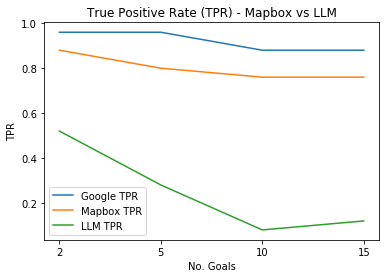

In [33]:
# Define the x-axis values
x = ['2', '5', '10', '15']

# Plot TPR for Mapbox and AI
plt.plot(x, TPR_recalls_google, label='Google TPR')
plt.plot(x, TPR_recalls_mapbox, label='Mapbox TPR')
plt.plot(x, TPR_recalls_ai, label='LLM TPR')

# Add labels and title
plt.xlabel('No. Goals')
plt.ylabel('TPR')
plt.title('True Positive Rate (TPR) - Mapbox vs LLM')
plt.legend()

# Show the plot
plt.show()

In [34]:
obs_data = [[] for _ in range(5)]

for id in intent_dic_ai:
    # Find the highest scoring intent

    id_parts = id.split(".")
    
    # Check if the last part of the ID ends with "2"
    if id_parts[-1] == '1':
      
        obs_data[0].append(id)
    if id_parts[-1] == '3':
     
        obs_data[1].append(id)
    if id_parts[-1] == '5':
      
        obs_data[2].append(id)
    if id_parts[-1] == '10':
     
        obs_data[3].append(id)
    if id_parts[-1] == '15':

        obs_data[4].append(id)
# obs_data


In [35]:
# Initialize counts

TPR_recalls_google, FNRs_google, FPRs_google, F1s_google = [], [], [], []
TPR_recalls_mapbox, FNRs_mapbox, FPRs_mapbox, F1s_mapbox = [], [], [], []
TPR_recalls_ai, FNRs_ai, FPRs_ai, F1s_ai = [], [], [], []

count = 0  # Reset count for each iteration


for obs in range(len(obs_data)):
    TP_ai, FN_ai, FP_ai, TN_ai = 0, 0, 0, 0
    TP_mapbox, FN_mapbox, FP_mapbox, TN_mapbox = 0, 0, 0, 0
    TP_google, FN_google, FP_google, TN_google = 0, 0, 0, 0
    for id_str in obs_data[obs]:
        for data_dict in data:
            if data_dict['id'] == id_str:
         
                # Check if the highest scoring intent matches the intent_goal
                if google_intention[id_str]:
                    # print(data_dict['id'])
                    TP_google += 1
                    TN_google += len(intent_dic_google[id_str]) - 1
                else:
                    # print(data_dict['id'])
                    FN_google += 1
                    FP_google += len(intent_dic_google[id_str]) - 1
                break 

        
        for data_dict in data:
            if data_dict['id'] == id_str:
               
                if mapbox_intention[id_str]:
                    # print(data_dict['id'])
                    TP_mapbox += 1
                    TN_mapbox += len(intent_dic_mapbox[id_str]) - 1
                else:
                    # print(data_dict['id'])
                    FN_mapbox += 1
                    FP_mapbox += len(intent_dic_mapbox[id_str]) - 1
                break



        for data_dict in data:
            if data_dict['id'] == id_str:
                
                if ai_intention[id_str]:
                    # print(data_dict['id'])
                    TP_ai += 1
                    TN_ai += len(intent_dic_ai[id_str]) - 1
                else:
                    # print(data_dict['id'])
                    FN_ai += 1
                    FP_ai += len(intent_dic_ai[id_str]) - 1
                break

        
  
    # print(TP_ai)
    # print(FN_ai)
    TPR_recall_google = TP_google/(TP_google + FN_google)
    Precision_google = TP_google/(TP_google + FP_google)
    FNR_google = FN_google/(FN_google + TP_google)
    FPR_google = FP_google/max(FP_google + TN_google, 1)
    
    F1s_google.append(round((2*Precision_google*TPR_recall_google)/(Precision_google + TPR_recall_google), 2))
    TPR_recalls_google.append(TPR_recall_google)
    FNRs_google.append(FNR_google)
    FPRs_google.append(FPR_google)

    # Calculate evaluation metrics, handle division by zero cases
    TPR_recall_mapbox = TP_mapbox / (TP_mapbox + FN_mapbox) 
    Precision_mapbox = TP_mapbox / (TP_mapbox + FP_mapbox)  
    FNR_mapbox = FN_mapbox / (FN_mapbox + TP_mapbox)  
    FPR_mapbox = FP_mapbox/(FP_mapbox + TN_mapbox)
    
    # Calculate F1 score, handle division by zero cases
    denominator = max(Precision_mapbox + TPR_recall_mapbox, 1)  # Ensuring the denominator is not zero

    F1s_mapbox.append(round((2 * Precision_mapbox * TPR_recall_mapbox) / denominator, 2))
    TPR_recalls_mapbox.append(round(TPR_recall_mapbox, 2))
    FNRs_mapbox.append(round(FNR_mapbox,2))
    FPRs_mapbox.append(round(FPR_mapbox,2))


    # Calculate evaluation metrics, handle division by zero cases
    TPR_recall_ai = TP_ai / max(TP_ai + FN_ai, 1)  # Ensuring the denominator is not zero
    Precision_ai = TP_ai / max(TP_ai + FP_ai, 1)  # Ensuring the denominator is not zero
    FNR_ai = FN_ai / max(FN_ai + TP_ai, 1)  # Ensuring the denominator is not zero
    
    # Calculate FPR, handle division by zero cases
    FPR_ai = FP_ai / max(FP_ai + TN_ai, 1)  # Ensuring the denominator is not zero
    
    # Calculate F1 score, handle division by zero cases
    denominator = max(Precision_ai + TPR_recall_ai, 1)  # Ensuring the denominator is not zero

    F1s_ai.append(round((2 * Precision_ai * TPR_recall_ai) / denominator, 2))
    TPR_recalls_ai.append(round(TPR_recall_ai,2))
    FNRs_ai.append(round(FNR_ai,2))
    FPRs_ai.append(round(FPR_ai,2))

# TPR_recalls_ai

In [36]:
# Define observation labels
observations = ['1', '3', '5', '10', '15']
observation_title = 'No. obs'

# Create DataFrames for each data source
df_google = pd.DataFrame({
    'TPR': TPR_recalls_google,
    'FNR': FNRs_google,
    'FPR': FPRs_google,
    'F1': F1s_google
}, index=observations)

df_mapbox = pd.DataFrame({
    'TPR': TPR_recalls_mapbox,
    'FNR': FNRs_mapbox,
    'FPR': FPRs_mapbox,
    'F1': F1s_mapbox
}, index=observations)

df_ai = pd.DataFrame({
    'TPR': TPR_recalls_ai,
    'FNR': FNRs_ai,
    'FPR': FPRs_ai,
    'F1': F1s_ai
}, index=observations)

# Create an empty DataFrame as the separator row
separator_row_1 = pd.DataFrame(' ', index=observations, columns=['Google'])
separator_row_2 = pd.DataFrame(' ', index=observations, columns=['Mapbox'])
separator_row_3 = pd.DataFrame(' ', index=observations, columns=['LLM'])


# Concatenate the DataFrames with separator rows
result_df = pd.concat([separator_row_1, df_google, separator_row_2, df_mapbox, separator_row_3, df_ai], axis=1)
result_df = result_df.rename_axis(observation_title)
# Display the result DataFrame
# print(result_df)
# Specify the folder path
folder_path = 'data_output'

# Check if the folder exists, if not, create it
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Write DataFrame to a CSV file in the specified folder
# result_df.to_csv(os.path.join(folder_path, 'result_dataframe_obs.csv'))


In [37]:
result_df

,Google,TPR,FNR,FPR,F1,Mapbox,TPR,FNR,FPR,F1,LLM,TPR,FNR,FPR,F1
No. obs,,,,,,,,,,,,,,,
1,,0.8,0.2,0.200000,0.50,,0.45,0.55,0.59,0.09,,0.20,0.80,0.86,0.01
3,,0.9,0.1,0.164286,0.59,,0.65,0.35,0.39,0.25,,0.30,0.70,0.82,0.03
5,,0.9,0.1,0.164286,0.59,,1.00,0.00,0.00,1.00,,0.25,0.75,0.92,0.02
10,,1.0,0.0,0.000000,1.00,,1.00,0.00,0.00,1.00,,0.25,0.75,0.79,0.02
15,,1.0,0.0,0.000000,1.00,,0.90,0.10,0.16,0.59,,0.25,0.75,0.89,0.02


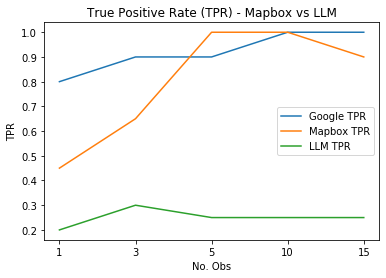

In [38]:
# Define the x-axis values
x = ['1', '3', '5', '10', '15']

# Plot TPR for Mapbox and LLM
plt.plot(x, TPR_recalls_google, label='Google TPR')
plt.plot(x, TPR_recalls_mapbox, label='Mapbox TPR')
plt.plot(x, TPR_recalls_ai, label='LLM TPR')

# Add labels and title
plt.xlabel('No. Obs')
plt.ylabel('TPR')
plt.title('True Positive Rate (TPR) - Mapbox vs LLM')
plt.legend()

# Show the plot
plt.show()
